# Analisis Predictivo de Series Temporales

## Curso 2023 - Universidad ORT Uruguay

## Parcial - Fecha 13/7/2023

### Nombre del estudiante: [completar]

In [ ]:
!pip install astsadata

In [ ]:
## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import statsmodels.api as sm
import pandas as pd
import statsmodels.formula.api as smf
import scipy as sp
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARIMA

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

In [67]:
def periodogram(x,sampling_frequency=1):

    """Función que calcula el periodograma y grafica.

    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    plt.plot(f,P);
    plt.xlabel("Frequency")
    plt.ylabel("Power")

def spectrum(x,sampling_frequency=1, nfreq=10):

    """Función que calcula las componentes más relevantes del periodograma.

    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    nfreq = np.minimum(nfreq,round(n/2)) #corto nfreq si la serie es muy corta!
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    index = np.argsort(P)[::-1] #ordeno P decreciente
    return pd.DataFrame({"Frecuencia" : f[index[0:nfreq]],"Potencia" : P[index[0:nfreq]]})

# Funcion que grafica correctamente la correlacion cruzada
def ccf(x, y, max_lag, ax=None, **kwargs):
    lags = np.arange(-max_lag, max_lag + 1)

    backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
    forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
    ccf = np.r_[backwards[:-1], forwards]
    ylabel = "CCF"

    if ax is None:
        ax = plt.gca()

    ax.stem(lags, ccf, basefmt="k")
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    conf_level = 1.96 / np.sqrt(x.shape[0])
    ax.fill_between(lags,conf_level,-conf_level,alpha=0.25)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)


    return ax

## Ejercicio 1

Uno de los problemas del mundo actual es el exceso de datos ("too much data" en lugar de "big data"). Una de las razones detrás de este problema es el descenso abrupto en los costos de almacenamiento, medidos en dólares por Gigabyte.

Se dispone de la siguiente serie de evolución de estos costos (mediana anual de precios en un conjunto de fabricantes de 1980 a 2008), almacenada en `cpg`:

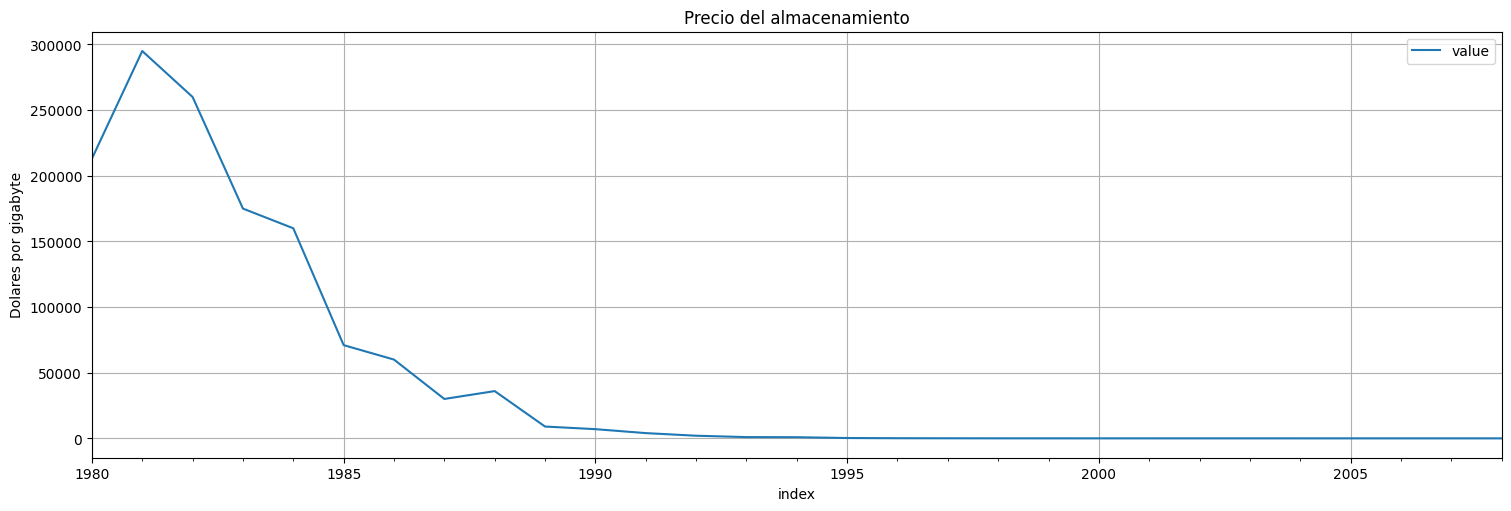

In [4]:
cpg = astsa.cpg
cpg.plot()
plt.title("Precio del almacenamiento")
plt.ylabel("Dolares por gigabyte");

1. Describir brevemente la serie observada. Argumentar que la serie presenta aproximadamente un descenso exponencial.
2. Transformar la serie a escala logarítmica $x_t = \log(cpg_t)$ y graficar nuevamente. Comentar lo observado.
3. Realizar una regresión lineal de la forma $x_t = \beta_0 + \beta_1 t$.
4. Graficar los valores ajustados y analizar los residuos y el ajuste obtenido.
5. Se propone agregar un término cuadrático (que corresponde a un decaimiento mayor a exponencial) a la regresión anterior. Realice nuevamente el ajuste y compare con el anterior. ¿Cuál modelo le parece mejor?

In [ ]:
La serie presenta una clara tendencia negativa en el tiempo y claramente no es estacionaria, por lo menos si se toma todo el período analizado.
Parecería presentar un descenso exponencial.

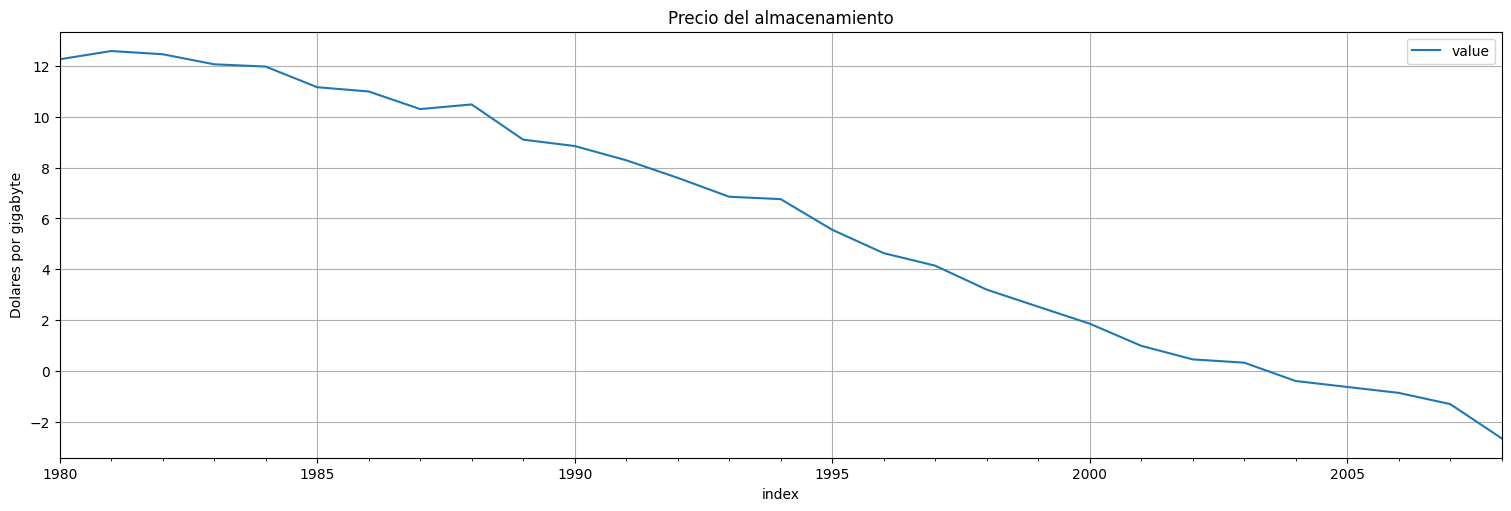

In [5]:
cpg_log = np.log(cpg)
cpg_log.plot()
plt.title("Precio del almacenamiento")
plt.ylabel("Dolares por gigabyte");

In [ ]:
La serie mantiene la tendencia negativa en el tiempo, aunque no exponencialmente.
Sigue sin ser estacionaria.

In [8]:
time = pd.Series([idx.ordinal for idx in cpg_log.index],index=cpg_log.index)
data = pd.concat([cpg_log,time],axis=1)
data.columns = ["cpg_log","time"]
cpg_logfit_linear = smf.ols(formula="cpg_log ~ time", data=data).fit()
cpg_logfit_linear_resid = cpg_logfit_linear.resid
cpg_logfit_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cpg_log   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1790.
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           3.23e-26
Time:                        17:51:19   Log-Likelihood:                -26.396
No. Observations:                  29   AIC:                             56.79
Df Residuals:                      27   BIC:                             59.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.8914      0.352     56.587      0.000      19.170      20.613
time          -0.5851      0.014    -42.304      0.000      -0.613      -0.557
==============================================================================
Omnibus:                        4.198   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                2.584
Skew:                          -0.628   Prob(JB):                        0.275
Kurtosis:                       3.749   Cond. No.                         77.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

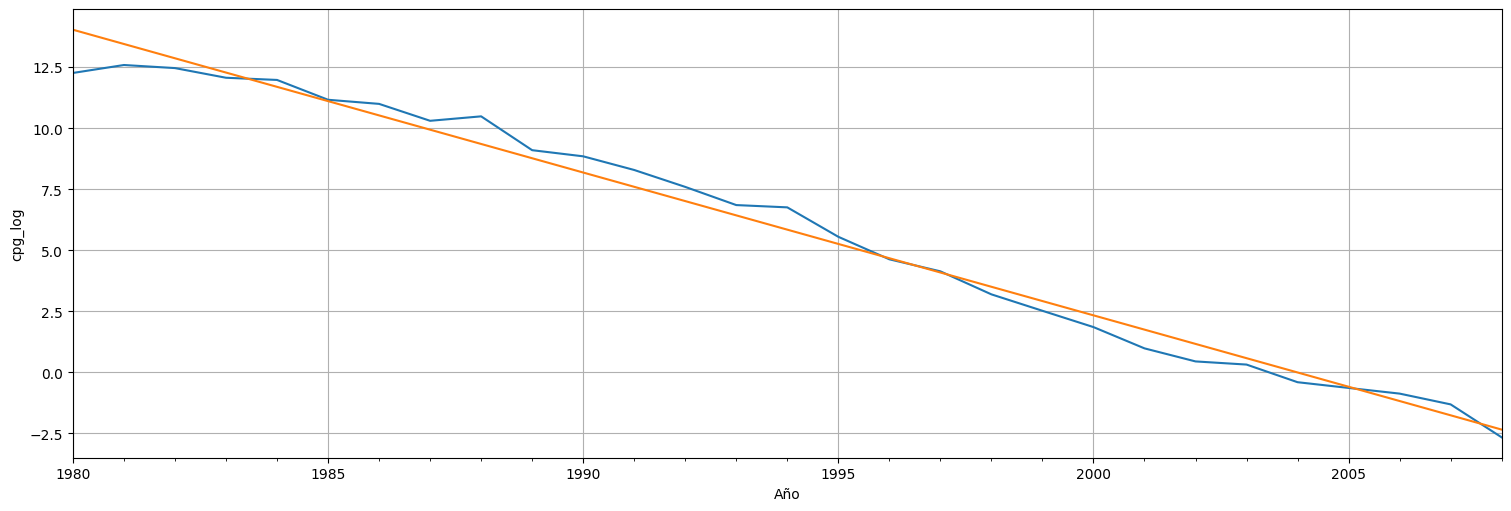

In [28]:
ax = cpg_log.plot(xlabel="Año", ylabel="cpg_log", legend=False)
ax.plot(cpg_logfit_linear.fittedvalues);

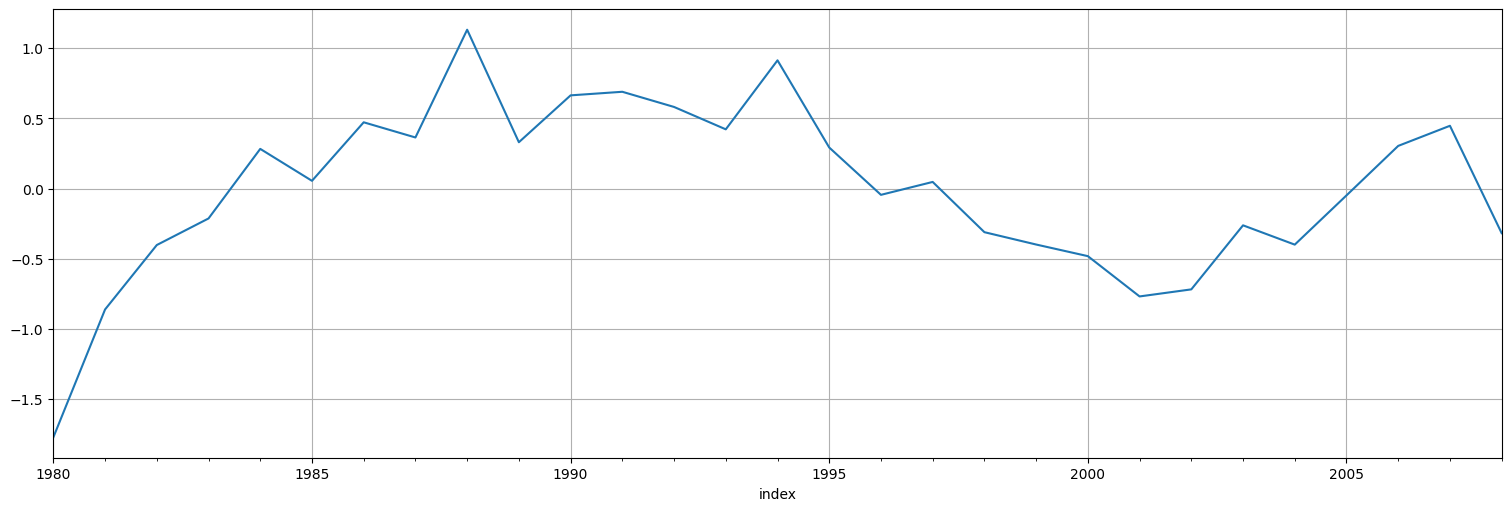

In [10]:
cpg_logfit_linear_resid.plot();

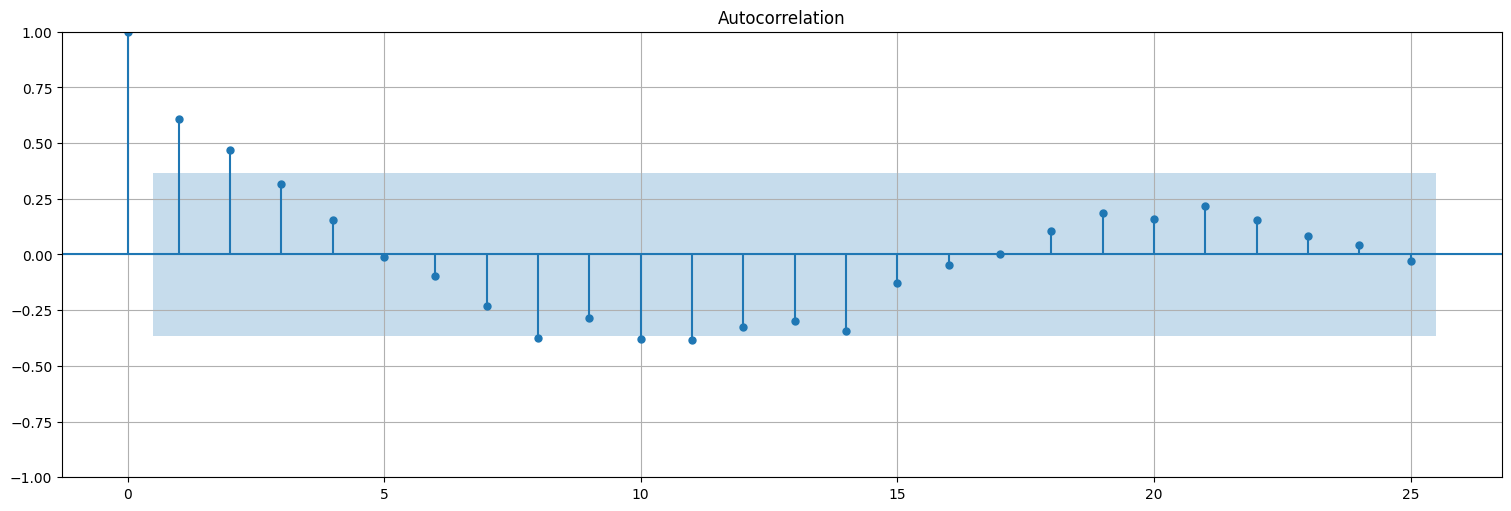

In [12]:
plot_acf(cpg_logfit_linear_resid, bartlett_confint=False, lags=25);

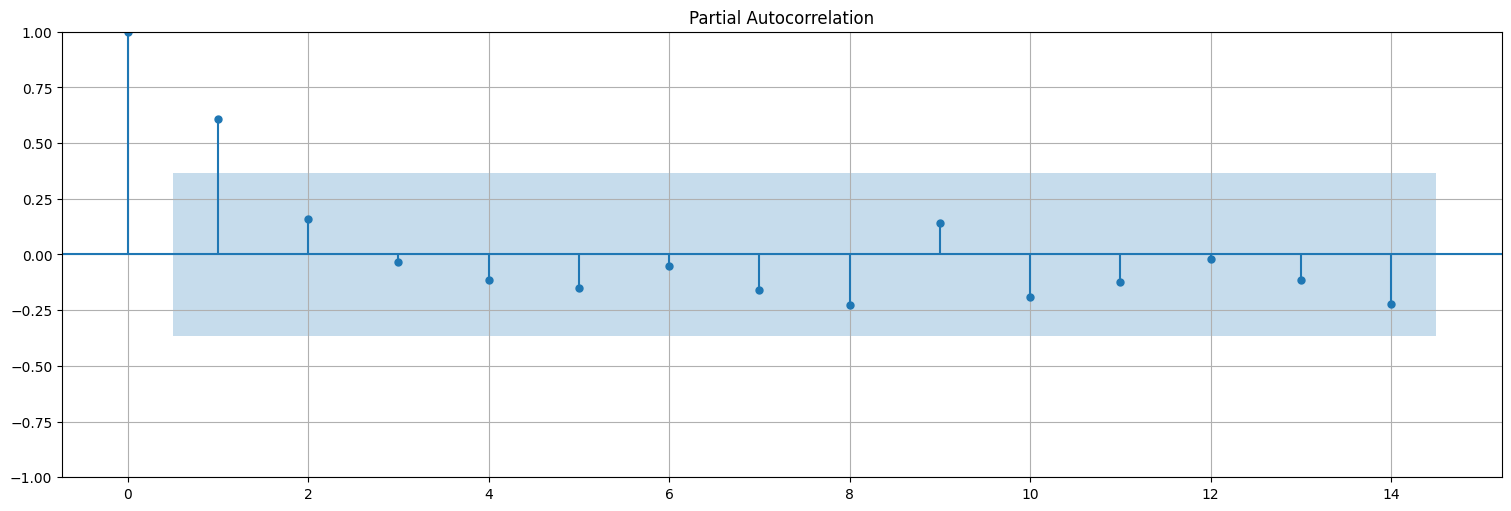

In [15]:
plot_pacf(cpg_logfit_linear_resid);

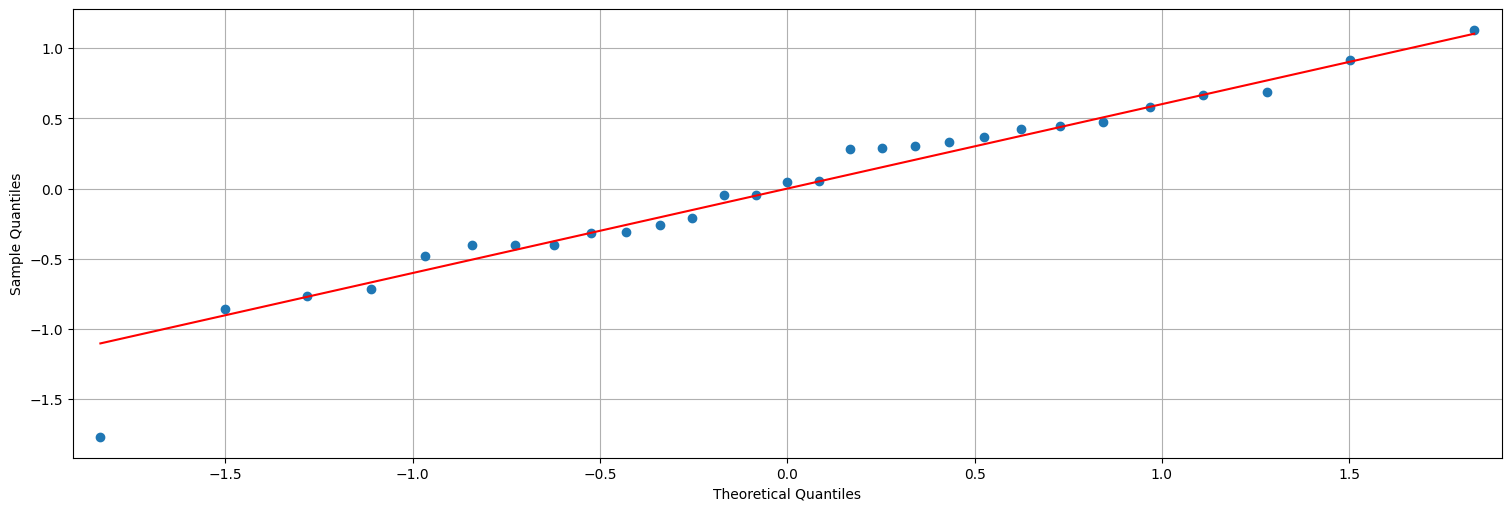

In [16]:
sm.qqplot(cpg_logfit_linear_resid, line="s");

In [17]:
time2 = time**2

data = pd.concat([cpg_log, time, time2],axis=1)
data.columns = ["cpg_log","time", "time2"]
cpg_logfit_cuad = smf.ols(formula="cpg_log ~ time + time2", data=data).fit()
cpg_logfit_cuad_resid = cpg_logfit_cuad.resid
cpg_logfit_cuad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cpg_log   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1164.
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           3.64e-26
Time:                        17:57:27   Log-Likelihood:                -22.092
No. Observations:                  29   AIC:                             50.18
Df Residuals:                      26   BIC:                             54.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.4245      0.879     19.822      0.000      15.618      19.231
time          -0.3511      0.079     -4.443      0.000      -0.513      -0.189
time2         -0.0049      0.002     -2.997      0.006      -0.008      -0.002
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   0.587
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.562
Skew:                          -0.227   Prob(JB):                        0.755
Kurtosis:                       2.492   Cond. No.                     6.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

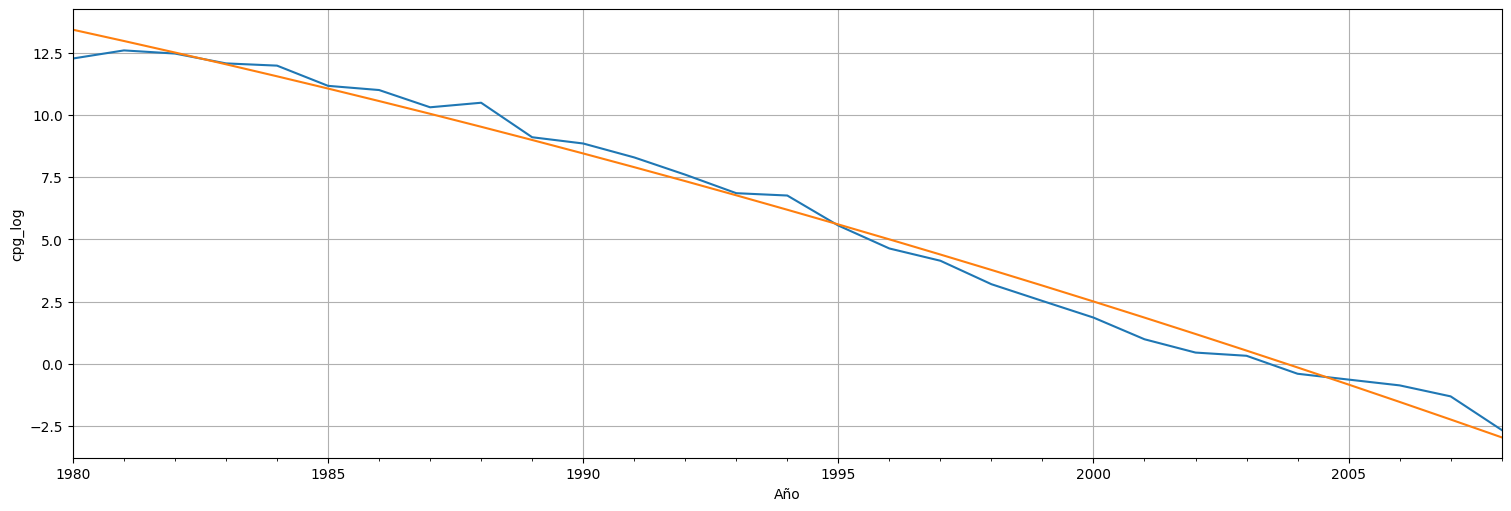

In [18]:
ax = cpg_log.plot(xlabel="Año", ylabel="cpg_log", legend=False)
ax.plot(cpg_logfit_cuad.fittedvalues);

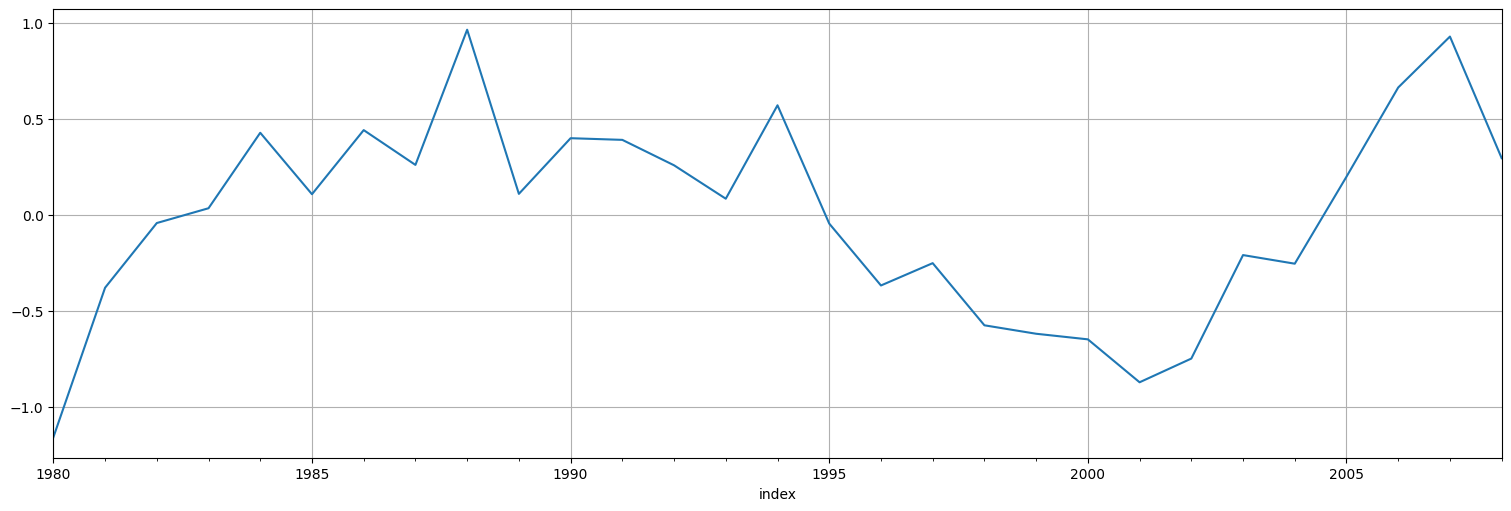

In [19]:
cpg_logfit_cuad_resid.plot();

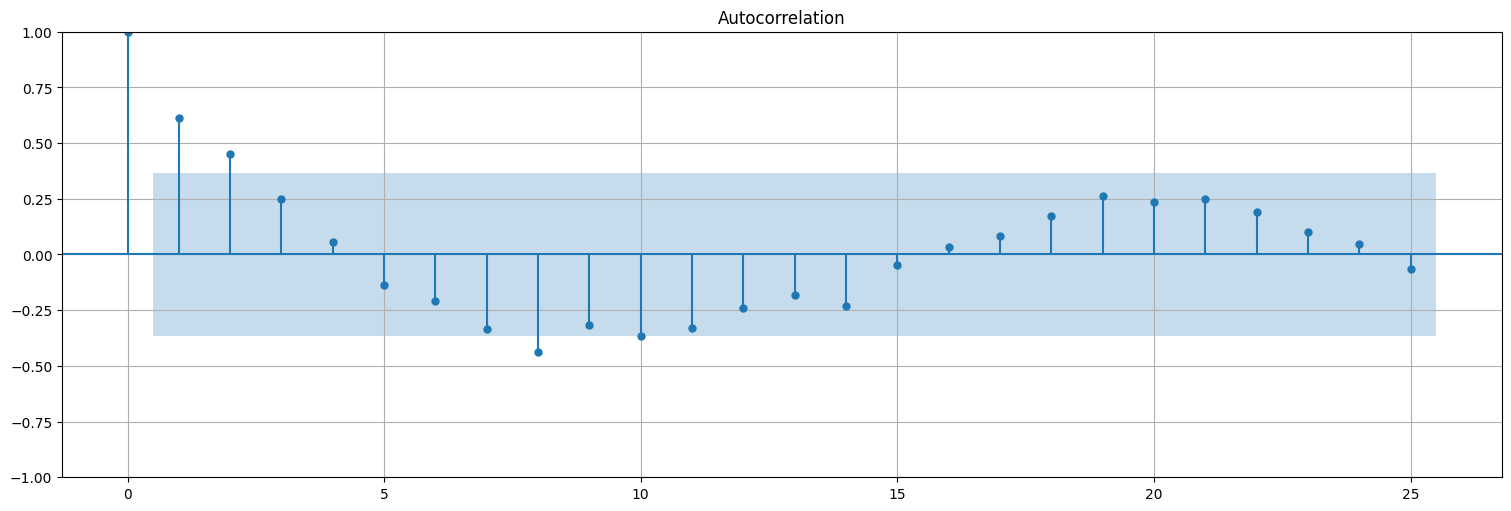

In [20]:
plot_acf(cpg_logfit_cuad_resid, bartlett_confint=False, lags=25);

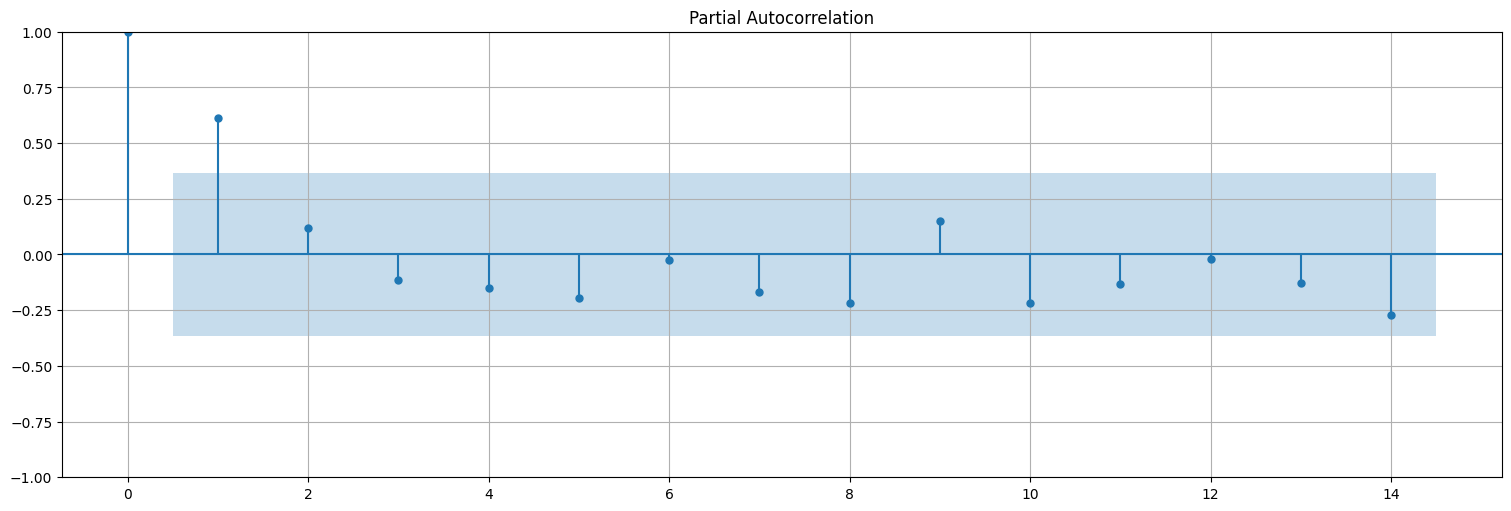

In [21]:
plot_pacf(cpg_logfit_cuad_resid);

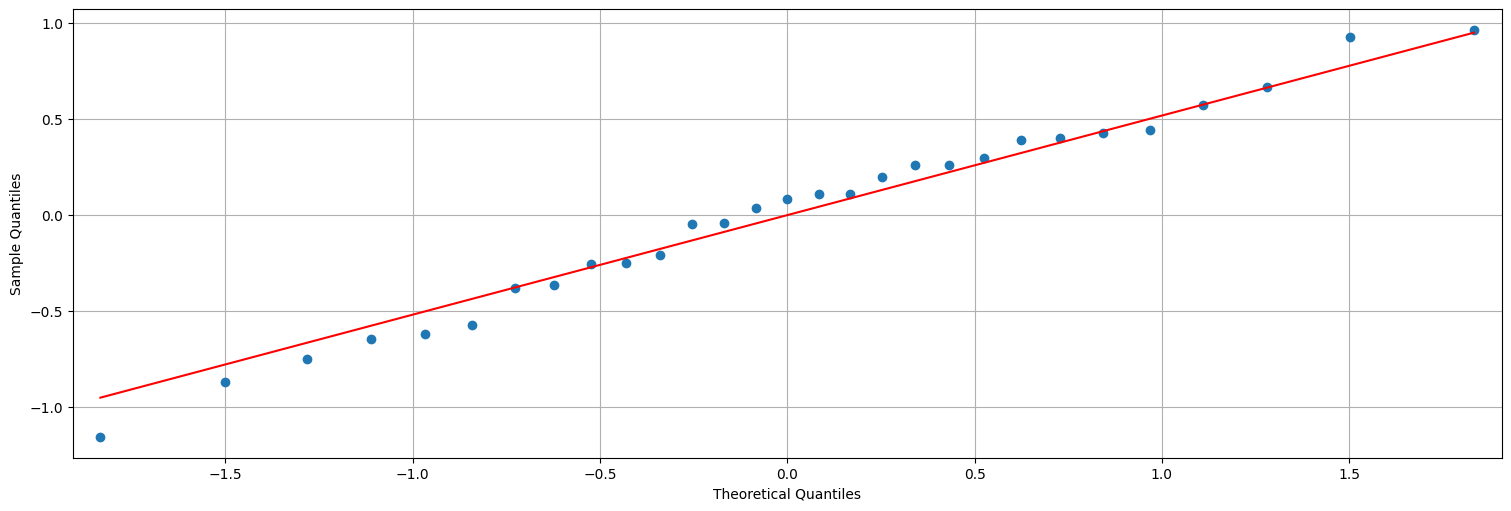

In [22]:
sm.qqplot(cpg_logfit_cuad_resid, line="s");

## Ejercicio 2

Se considera en primer lugar la serie `sales` de ventas de Oro en sudáfrica en el período Jul 1957 - Dic 1969. Se desea ajustar a dicha serie un modelo ARIMA adecuado.

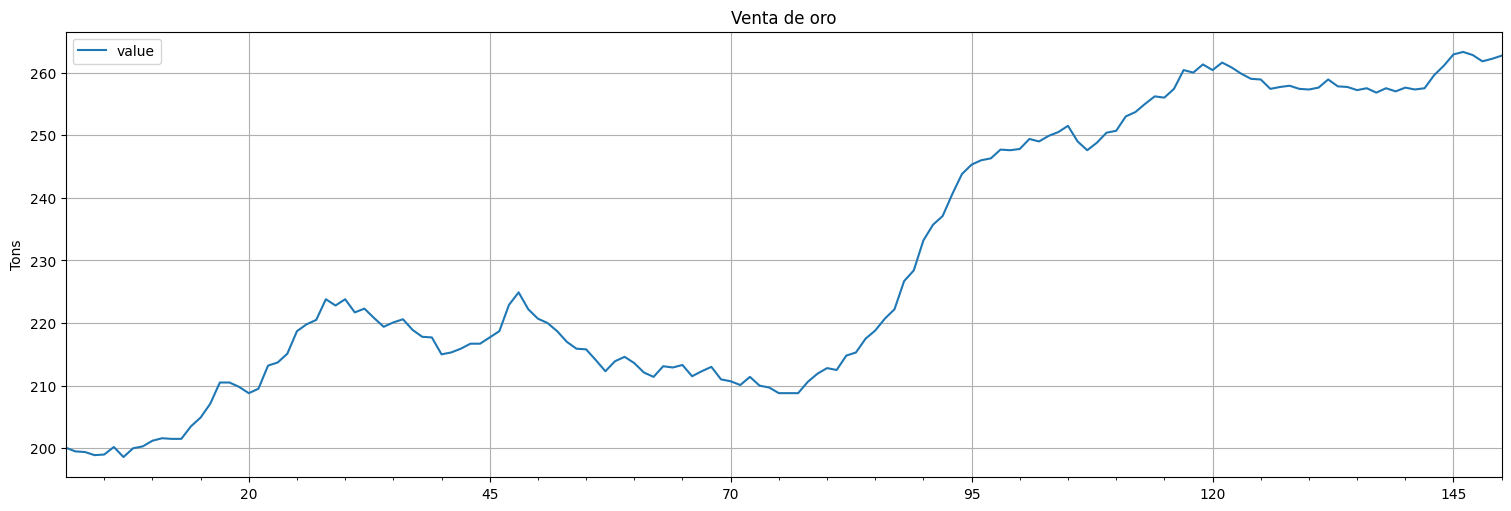

In [23]:
sales = astsa.sales
sales.plot()
plt.title("Venta de oro")
plt.ylabel("Tons");

Se pide:

   1. Analizar la serie anterior: ¿es estacionaria? ¿Presenta alguna tendencia clara?
   2. Analice la serie de incrementos de $y_t$. ¿Puede decir que es estacionaria? ¿Cuál es el incremento medio?
   3. Realice un análisis de autocorrelación de la serie diferenciada y elija dos modelos de tipo ARMA adecuados           para la misma.
   4. Ajuste los modelos anteriores a la serie original `sales` (no olvide incluir el orden de integración $I$). Compare los resultados obtenidos analizando los residuos y la calidad del ajuste.
   5. Elija el modelo que le parezca más adecuado y realice una predicción para el año 1970 incluyendo intervalos de confianza.
   

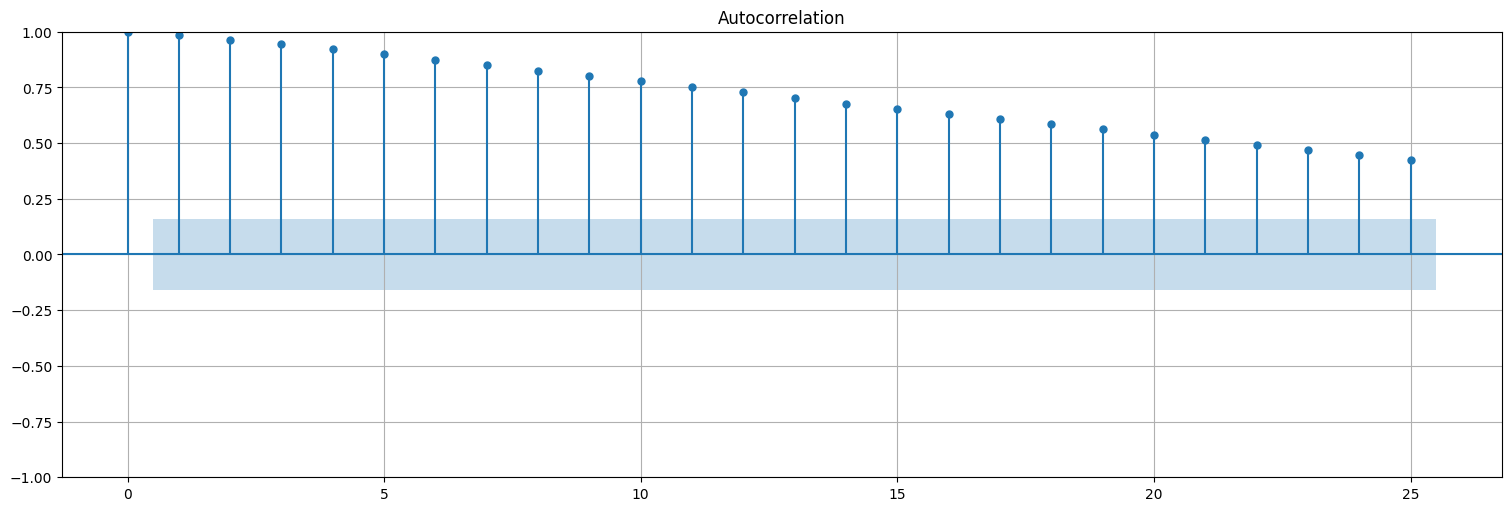

In [36]:
plot_acf(sales, bartlett_confint=False, lags=25);

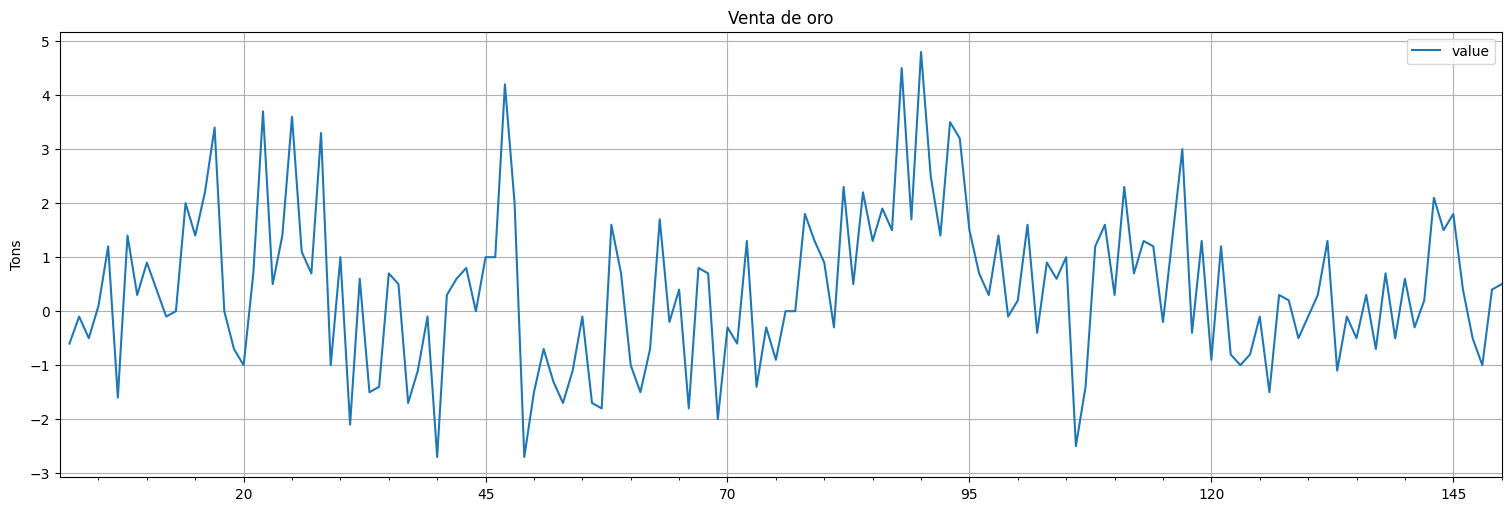

In [25]:
salesdiff = sales.diff()
salesdiff.plot()
plt.title("Venta de oro")
plt.ylabel("Tons");

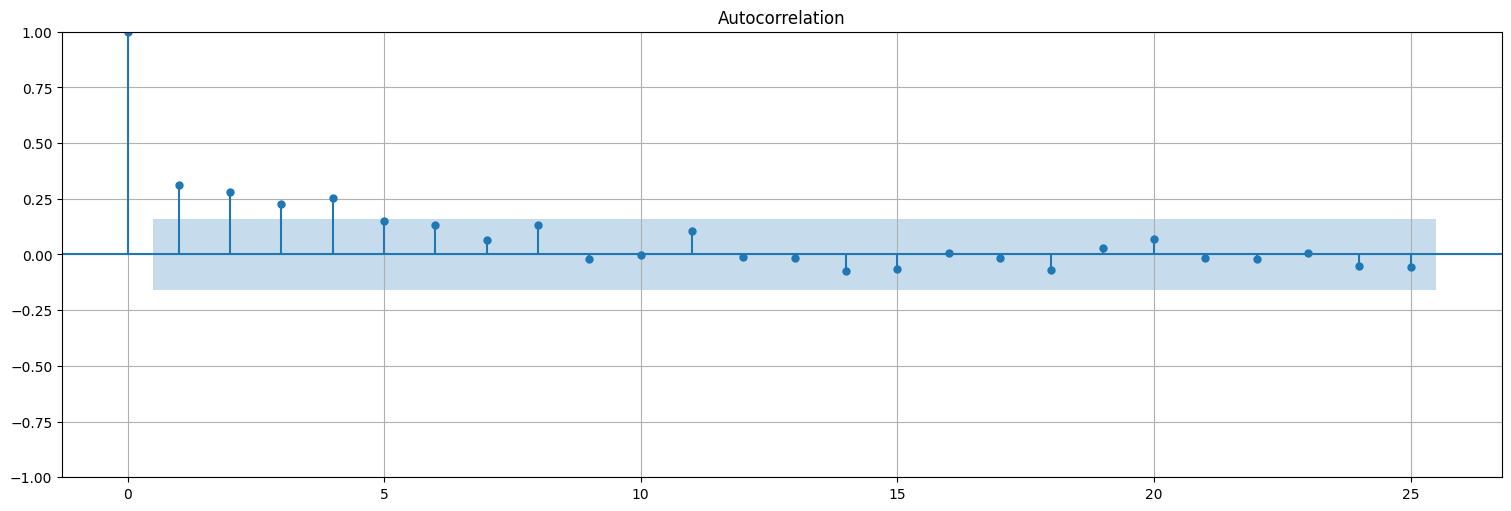

In [32]:
plot_acf(salesdiff.dropna(), bartlett_confint=False, lags=25);

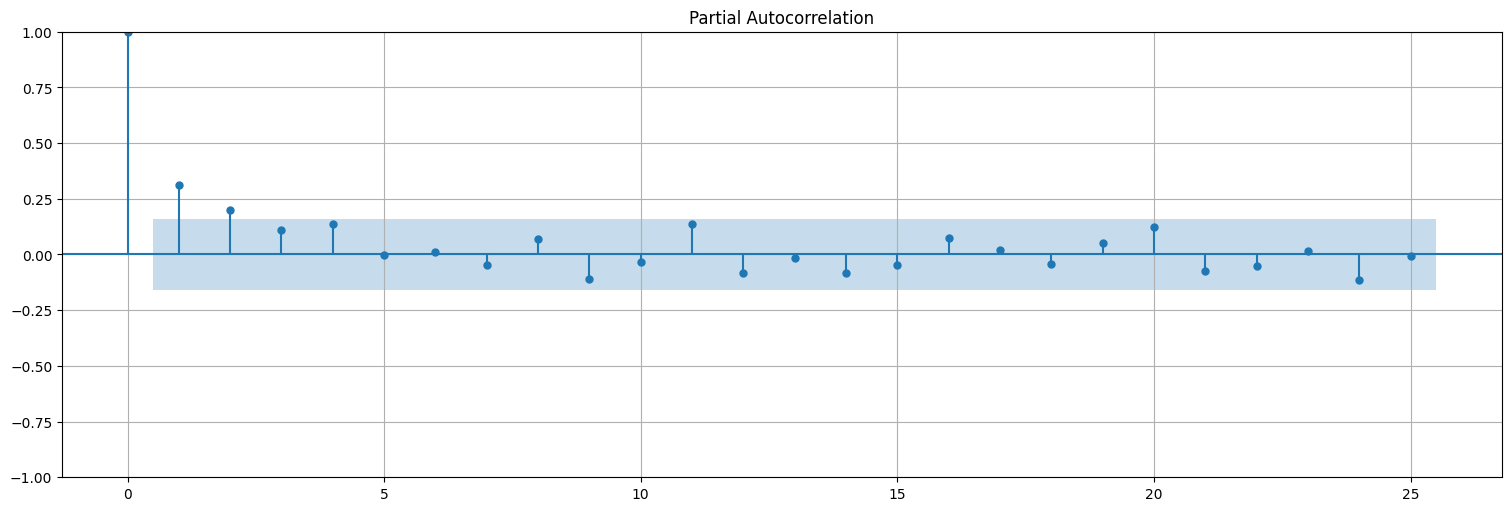

In [34]:
plot_pacf(salesdiff.dropna(), lags=25);

In [40]:
fitar2 = ARIMA(salesdiff,order=(2,0,0), trend="n").fit()
fitar2_resid = fitar2.resid
fitar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  150
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -256.961
Date:                Thu, 04 Jul 2024   AIC                            519.923
Time:                        18:13:54   BIC                            528.955
Sample:                      12-31-01   HQIC                           523.592
                          - 12-31-150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2799      0.096      2.903      0.004       0.091       0.469
ar.L2          0.2301      0.075      3.088      0.002       0.084       0.376
sigma2         1.8397      0.189      9.731      0.000       1.469       2.210
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.50   Prob(JB):                         0.31
Heteroskedasticity (H):               0.49   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
fitar1ma1 = ARIMA(salesdiff,order=(1,0,1), trend="n").fit()
fitar1ma1_resid = fitar1ma1.resid
fitar1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  150
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -254.368
Date:                Thu, 04 Jul 2024   AIC                            514.736
Time:                        18:14:37   BIC                            523.768
Sample:                      12-31-01   HQIC                           518.405
                          - 12-31-150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8799      0.076     11.644      0.000       0.732       1.028
ma.L1         -0.6415      0.131     -4.889      0.000      -0.899      -0.384
sigma2         1.7755      0.191      9.287      0.000       1.401       2.150
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.75   Prob(JB):                         0.56
Heteroskedasticity (H):               0.49   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
fitar2 = ARIMA(sales,order=(2,1,0), trend="t").fit()
fitar2_resid = fitar2.resid
fitar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  150
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -255.034
Date:                Thu, 04 Jul 2024   AIC                            518.067
Time:                        18:18:05   BIC                            530.083
Sample:                      12-31-01   HQIC                           522.949
                          - 12-31-150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4138      0.208      1.992      0.046       0.007       0.821
ar.L1          0.2485      0.100      2.494      0.013       0.053       0.444
ar.L2          0.1988      0.074      2.682      0.007       0.054       0.344
sigma2         1.7935      0.187      9.582      0.000       1.427       2.160
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.27
Prob(Q):                              0.79   Prob(JB):                         0.32
Heteroskedasticity (H):               0.49   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
fitar1ma1 = ARIMA(sales,order=(1,1,1), trend="n").fit()
fitar1ma1_resid = fitar1ma1.resid
fitar1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  150
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.368
Date:                Thu, 04 Jul 2024   AIC                            514.736
Time:                        18:18:22   BIC                            523.748
Sample:                      12-31-01   HQIC                           518.397
                          - 12-31-150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8799      0.076     11.644      0.000       0.732       1.028
ma.L1         -0.6415      0.131     -4.889      0.000      -0.899      -0.384
sigma2         1.7755      0.191      9.287      0.000       1.401       2.150
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.04
Prob(Q):                              0.75   Prob(JB):                         0.60
Heteroskedasticity (H):               0.49   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

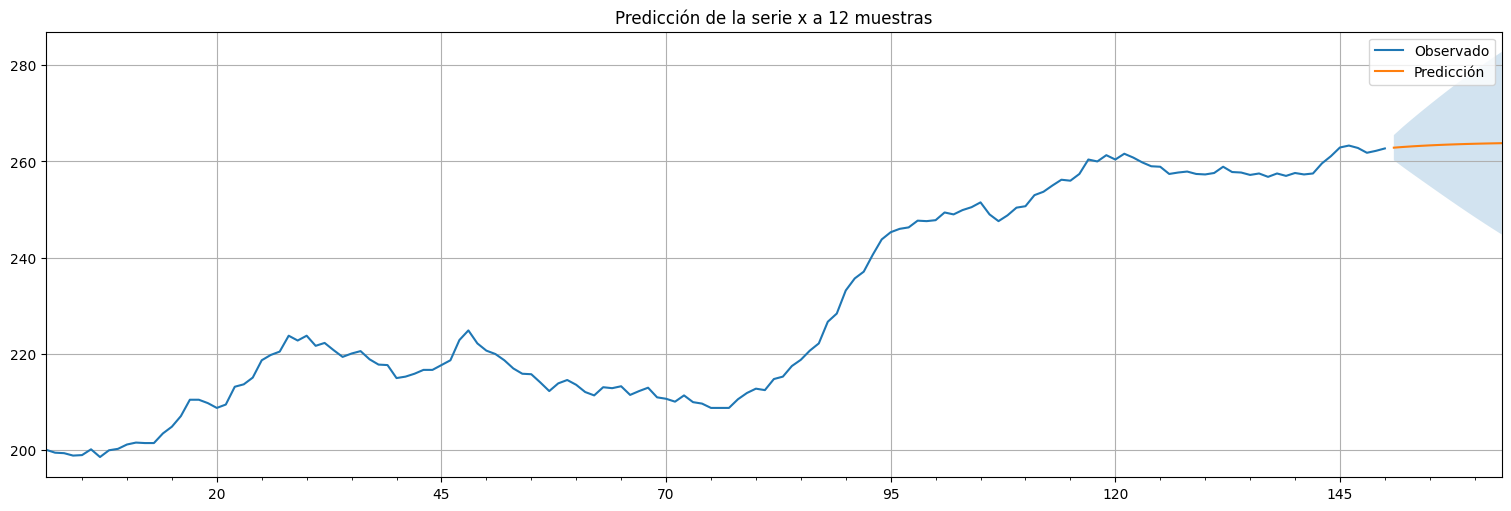

In [57]:
h = 12 #horizonte de predicción
predicciones = fitar1ma1.get_prediction(start=sales.size,end=sales.size+h)
xhat = predicciones.predicted_mean
confint = predicciones.conf_int(alpha=0.05) #alpha es la confianza del intervalo
sales.plot()
xhat.plot()
plt.legend(["Observado","Predicción"])
plt.fill_between(xhat.index,confint["lower value"], confint["upper value"], alpha=0.2);
plt.title(f"Predicción de la serie x a {h} muestras");

## Ejercicio 3

A la serie anterior de `sales` se le agrega ahora el indicador de precio del oro en el mercado internacional, dado por la serie `lead`.

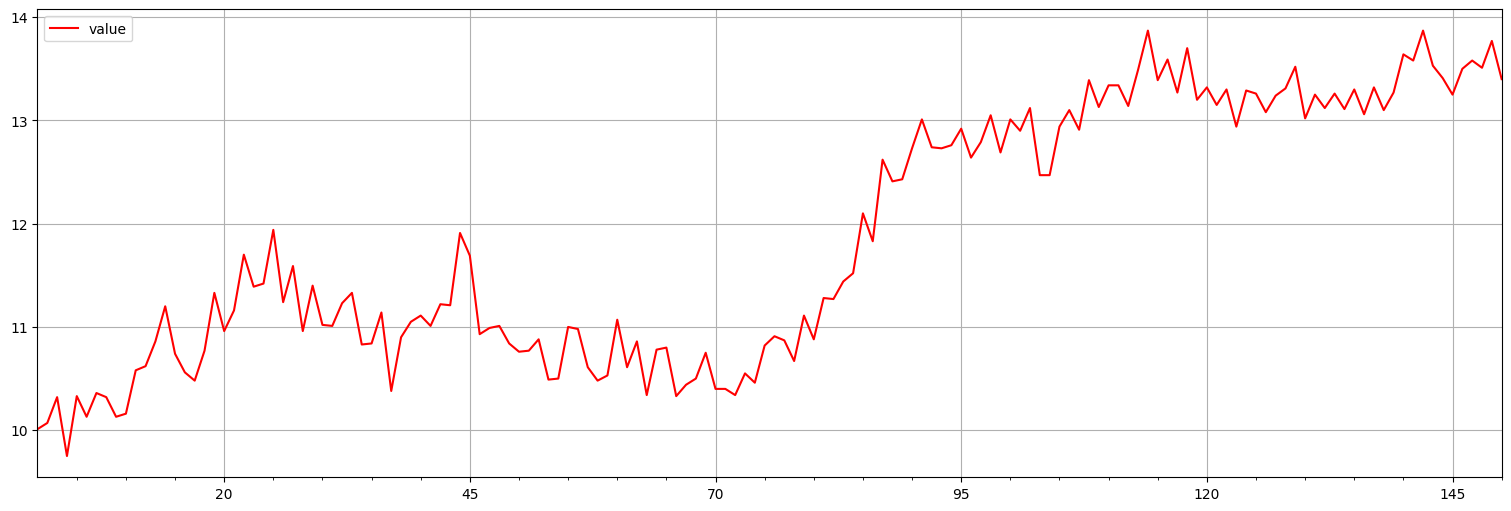

In [58]:
lead = astsa.lead
lead.plot(color="r");

1. Realice un modelo lineal que intente explicar el valor de $y$ (`sales`) directamente a partir del valor de $x$ (`lead`) y analice el resultado.
2. Se puede suponer que las producción (y por consiguiente las ventas) aumentan al aumentar el precio, pero con retardo. para ello se propone.
   1. Considerar las series $\nabla y$ y $\nabla x$ de incrementos de ventas y precio respectivamente.
   2. Realizar un análisis de correlación cruzada entre los mismos, y encontrar el lag entre las series que produce mayor correlación.
    
3. Con el lag obtenido, volver a realizar el ajuste de $y$ pero con la serie $x$ laggeada y comparar con la parte 1. Graficar adecuadamente el resultado.
4. Analizar los residuos y comentar si queda correlación y qué modelo propondría para el resultante (no hacer el modelo).


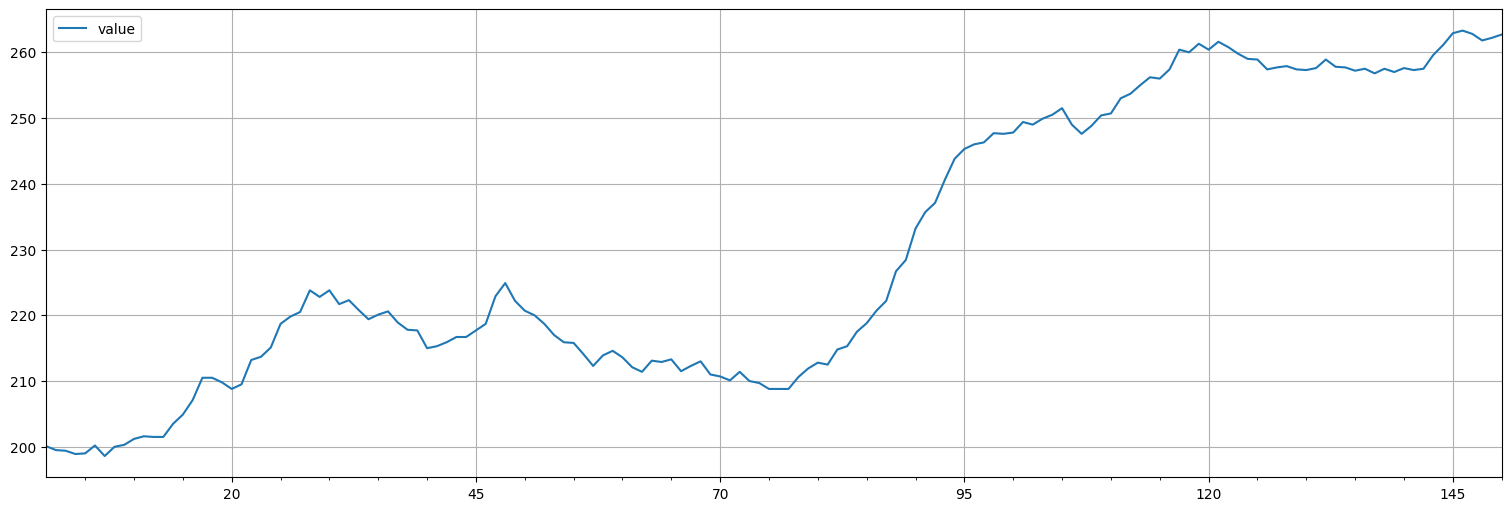

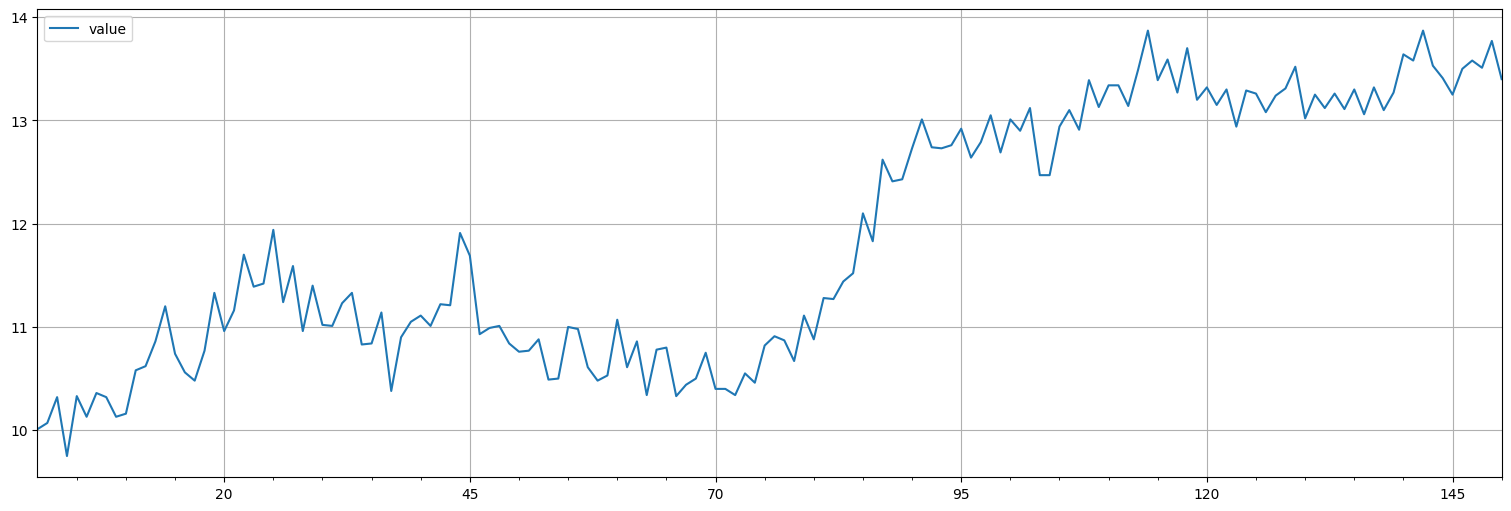

In [63]:
sales.plot(label="Oro");
lead.plot(label="Lead");
plt.legend();

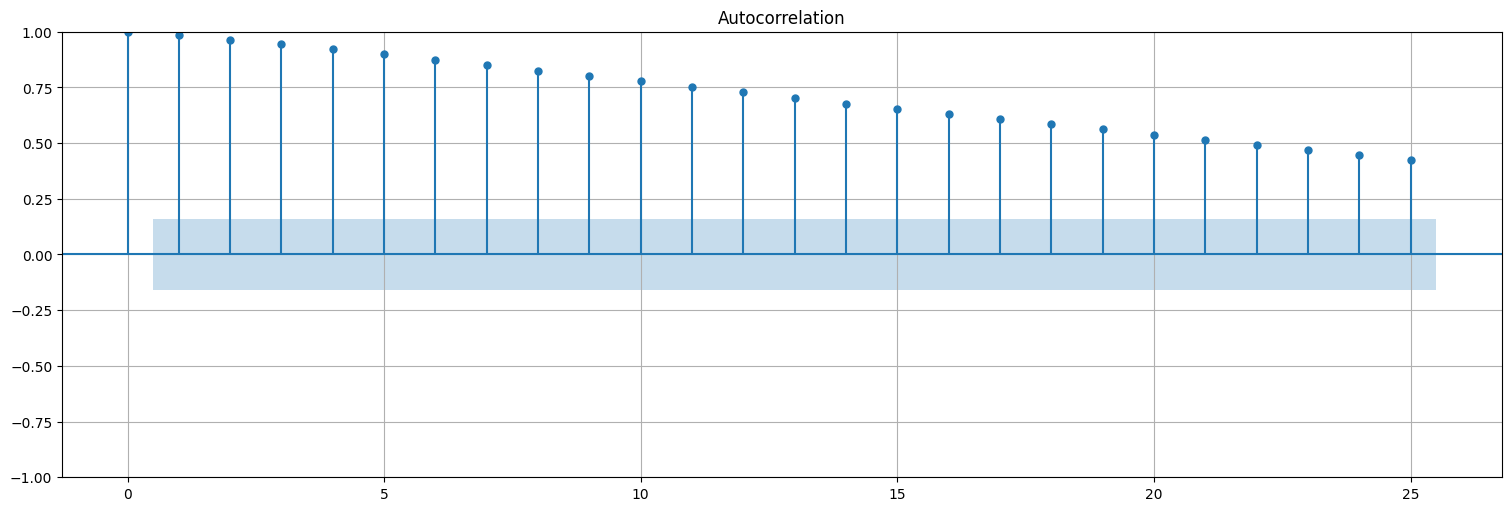

In [64]:
plot_acf(sales, bartlett_confint=False, lags=25);

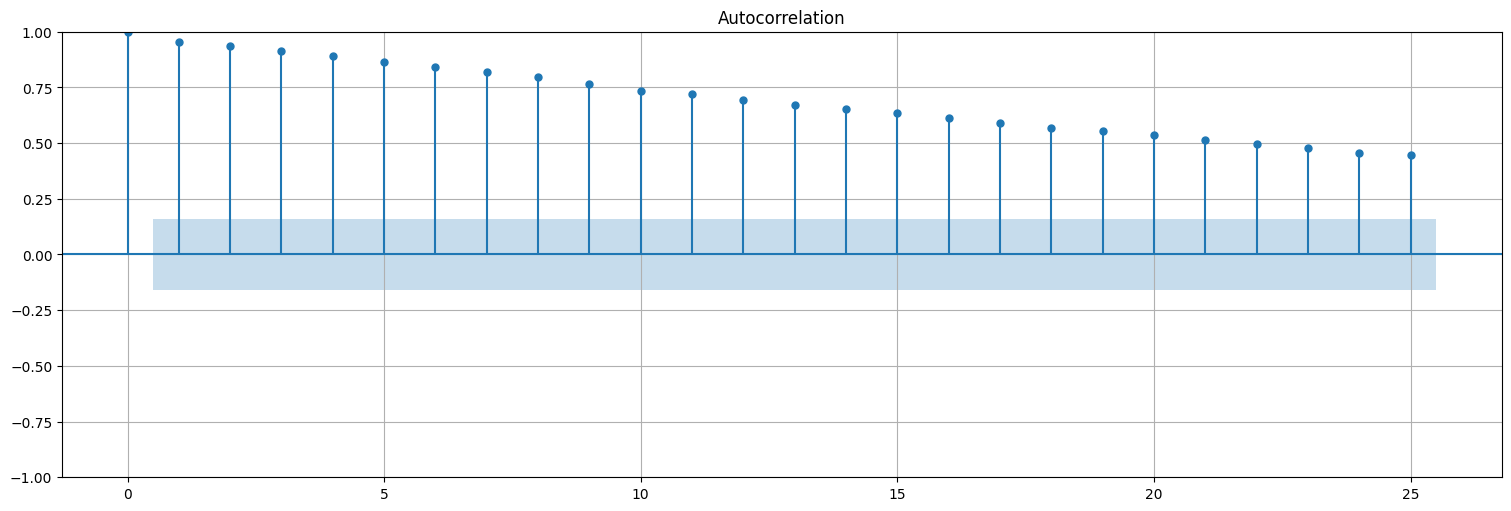

In [65]:
plot_acf(lead, bartlett_confint=False, lags=25);

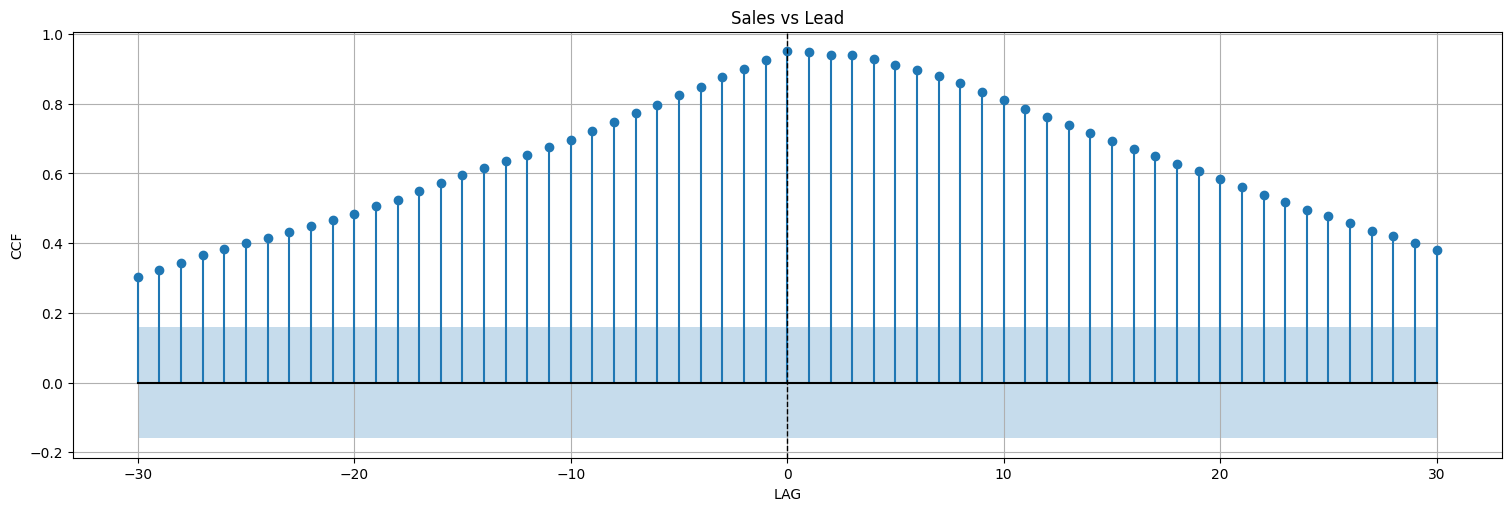

In [68]:
ccf(sales,lead, max_lag=30)
plt.title("Sales vs Lead");

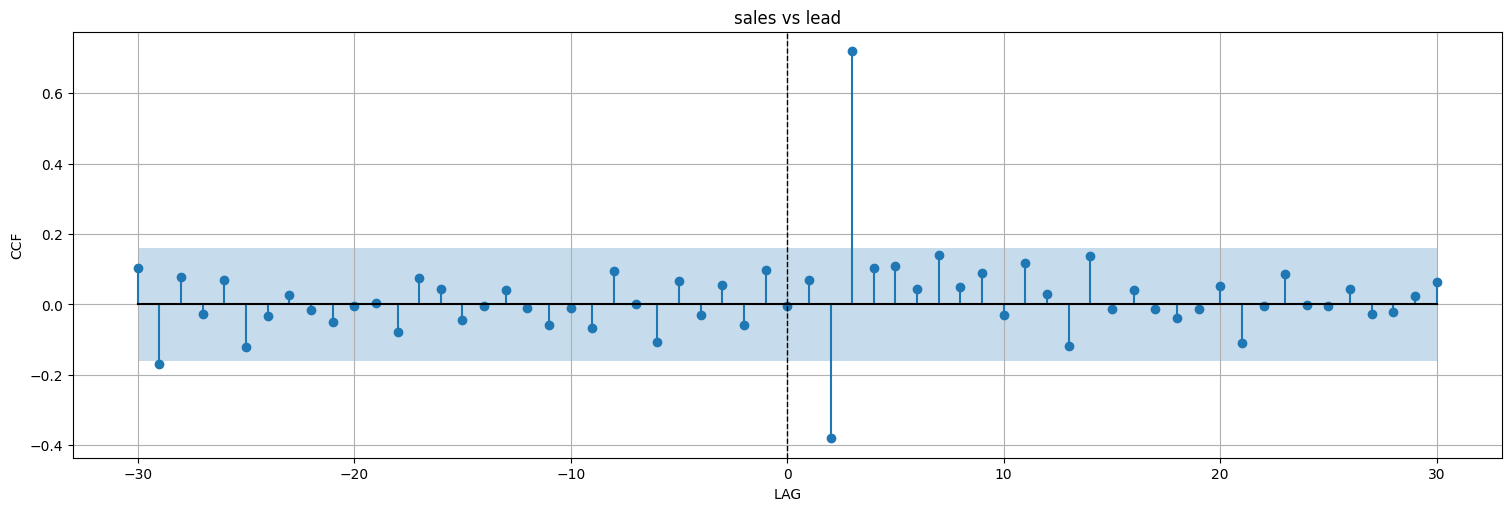

In [71]:
salesdiff = sales.diff()
leaddiff = lead.diff()
ccf(salesdiff.dropna(),leaddiff.dropna(), max_lag=30)
plt.title("sales vs lead");

In [81]:
datos = pd.concat([salesdiff, leaddiff.shift(2)], axis=1).dropna()
datos.columns = ["salesdiff", "leaddiffL2"]

salesdifffit = ols(formula="salesdiff ~ leaddiffL2", data=datos).fit()
salesdifffit_resid = salesdifffit.resid
salesdifffit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salesdiff   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     25.06
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           1.59e-06
Time:                        18:41:30   Log-Likelihood:                -251.06
No. Observations:                 147   AIC:                             506.1
Df Residuals:                     145   BIC:                             512.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4726      0.111      4.250      0.000       0.253       0.692
leaddiffL2    -1.7617      0.352     -5.006      0.000      -2.457      -1.066
==============================================================================
Omnibus:                        5.109   Durbin-Watson:                   0.706
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.733
Skew:                           0.431   Prob(JB):                       0.0938
Kurtosis:                       3.176   Cond. No.                         3.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

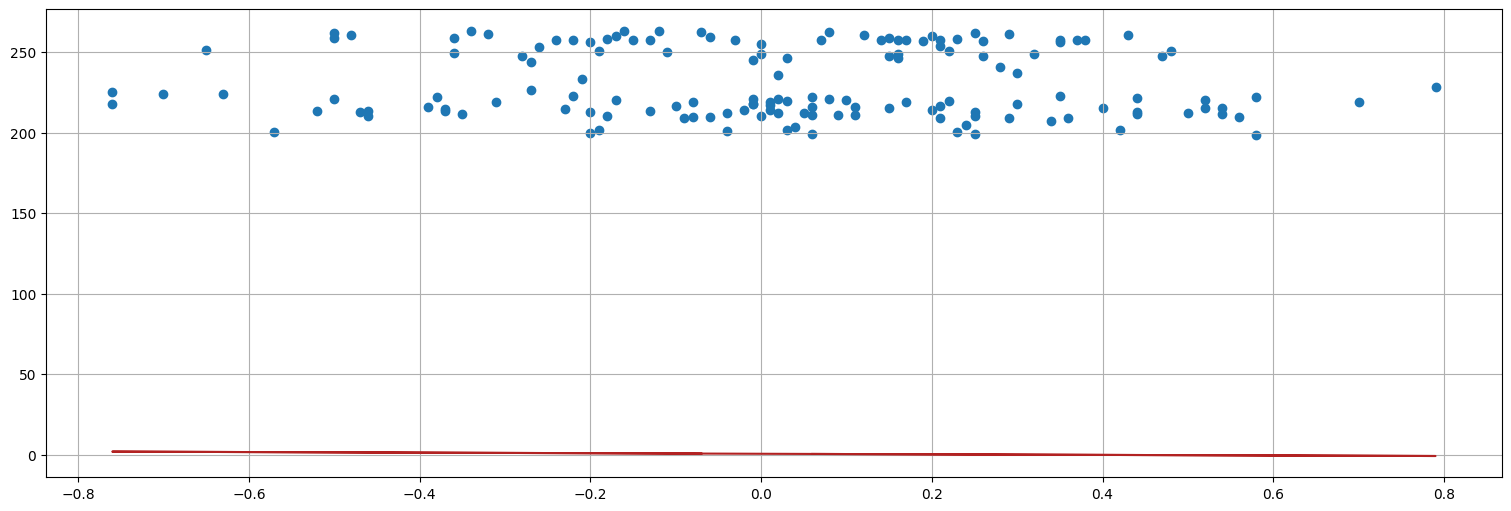

In [82]:
plt.plot(datos.leaddiffL2,salesdifffit.fittedvalues, color="firebrick")
plt.scatter(leaddiff.shift(2), sales);

In [89]:
datos = pd.concat([sales, lead.shift(1), lead.shift(2)], axis=1).dropna()
datos.columns = ["sales", "leadL1", "leadL2"]

salesfit = ols(formula="sales ~ leadL1 + leadL2", data=datos).fit()
salesfit_resid = salesfit.resid
salesfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1242.
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           5.71e-92
Time:                        18:46:41   Log-Likelihood:                -447.98
No. Observations:                 148   AIC:                             902.0
Df Residuals:                     145   BIC:                             910.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.4654      4.134      6.159      0.000      17.294      33.637
leadL1         6.6356      1.329      4.994      0.000       4.009       9.262
leadL2        10.6821      1.330      8.031      0.000       8.053      13.311
==============================================================================
Omnibus:                        4.957   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.062
Skew:                          -0.435   Prob(JB):                       0.0796
Kurtosis:                       2.748   Cond. No.                         168.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

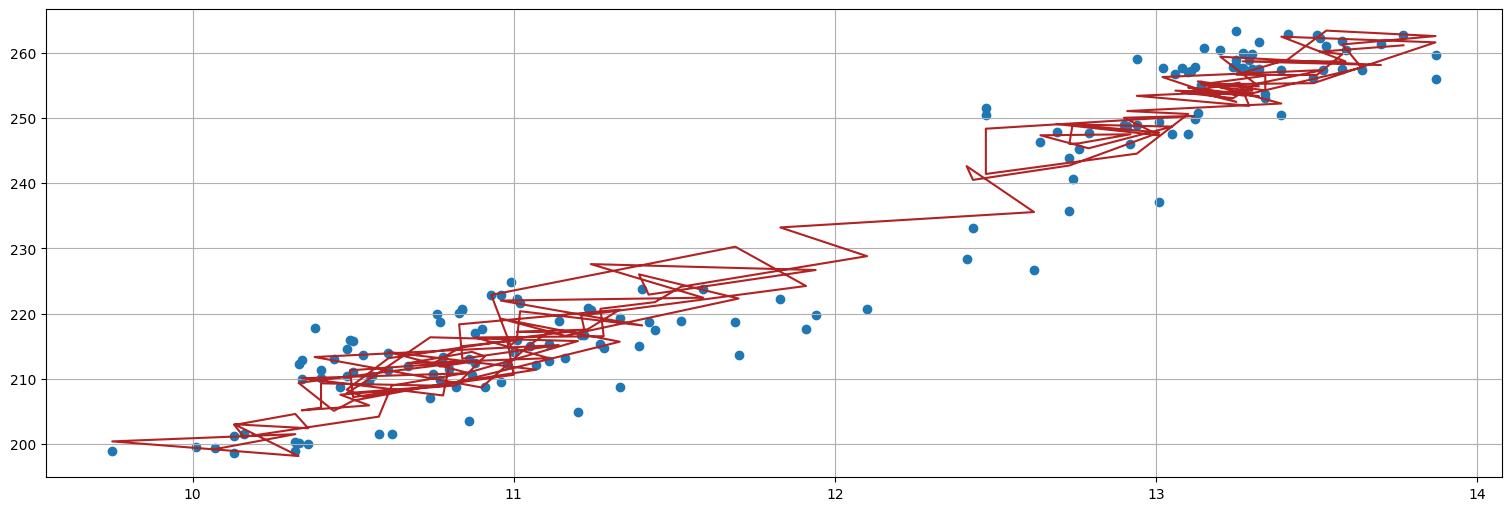

In [90]:
plt.plot(datos.leadL1,salesfit.fittedvalues, color="firebrick")
plt.scatter(lead.shift(1), sales);

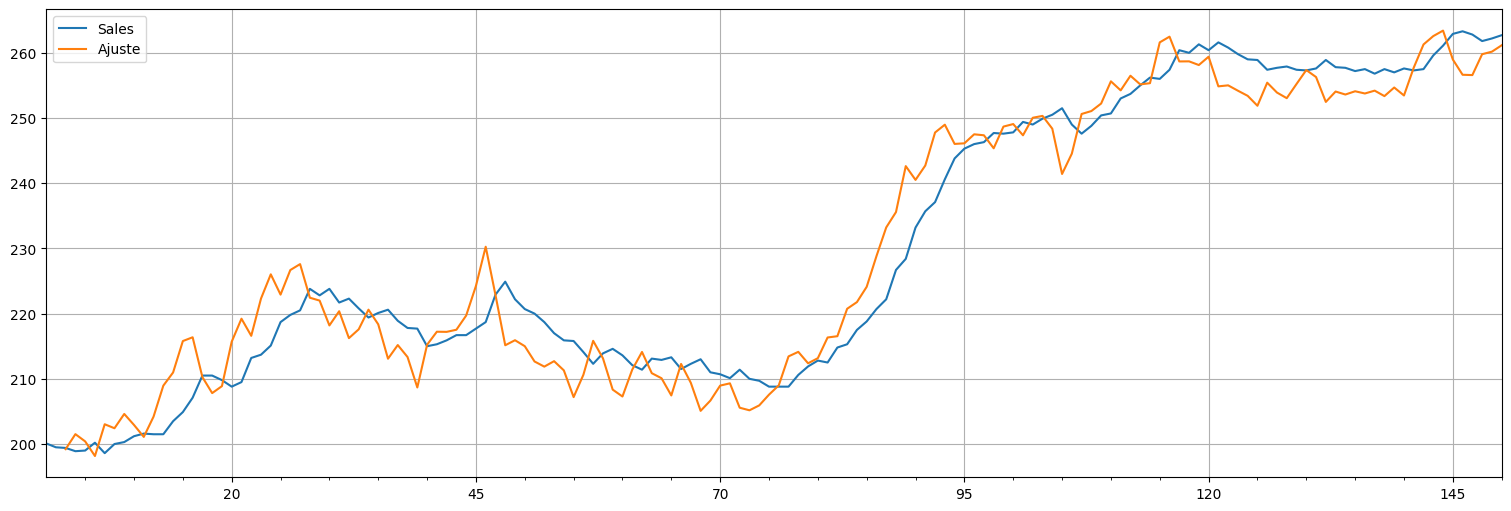

In [91]:
sales.plot()
salesfit.fittedvalues.plot().legend(["Sales","Ajuste"]);

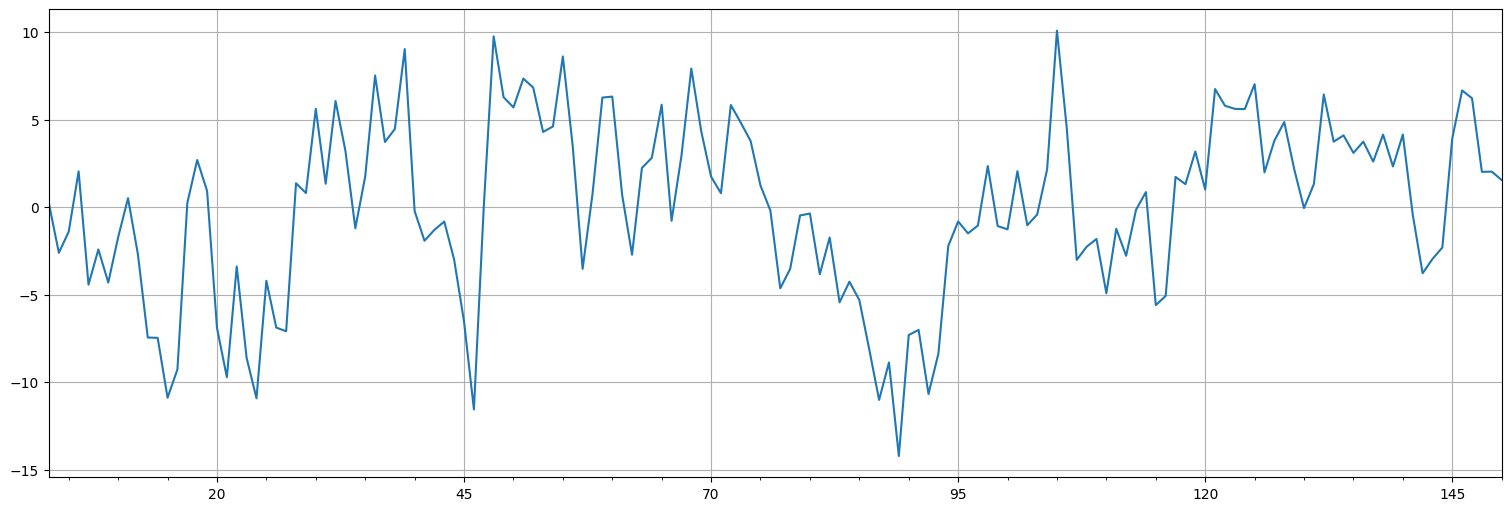

In [92]:
salesfit_resid.plot();

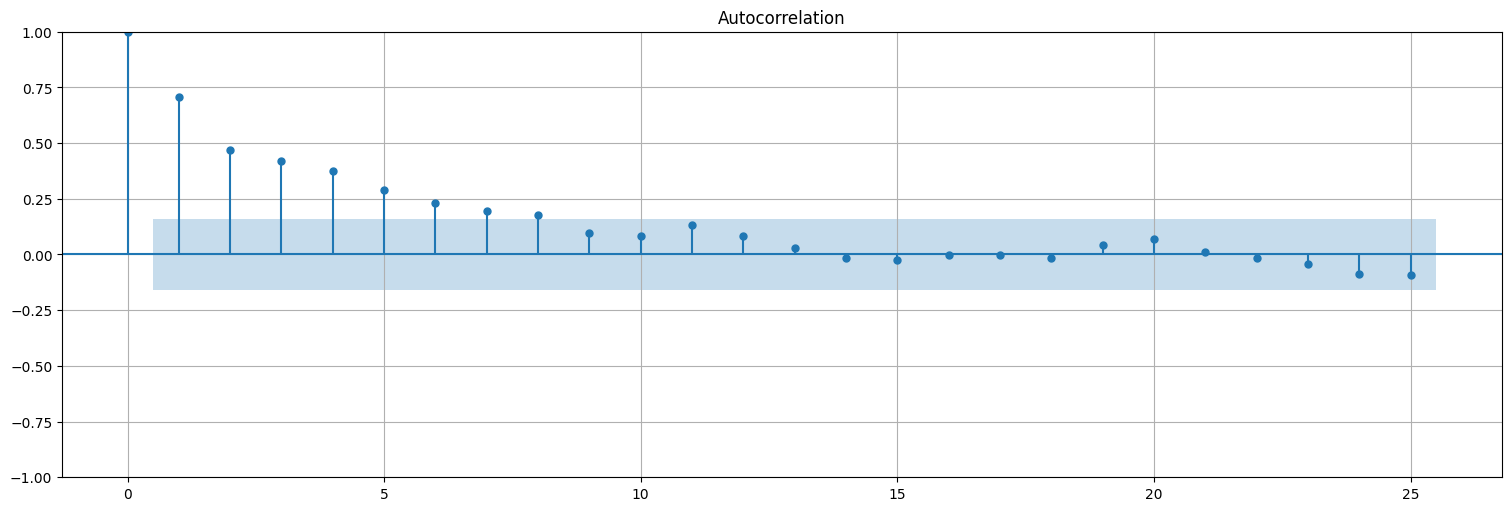

In [94]:
plot_acf(salesfit_resid,bartlett_confint=False, lags=25);

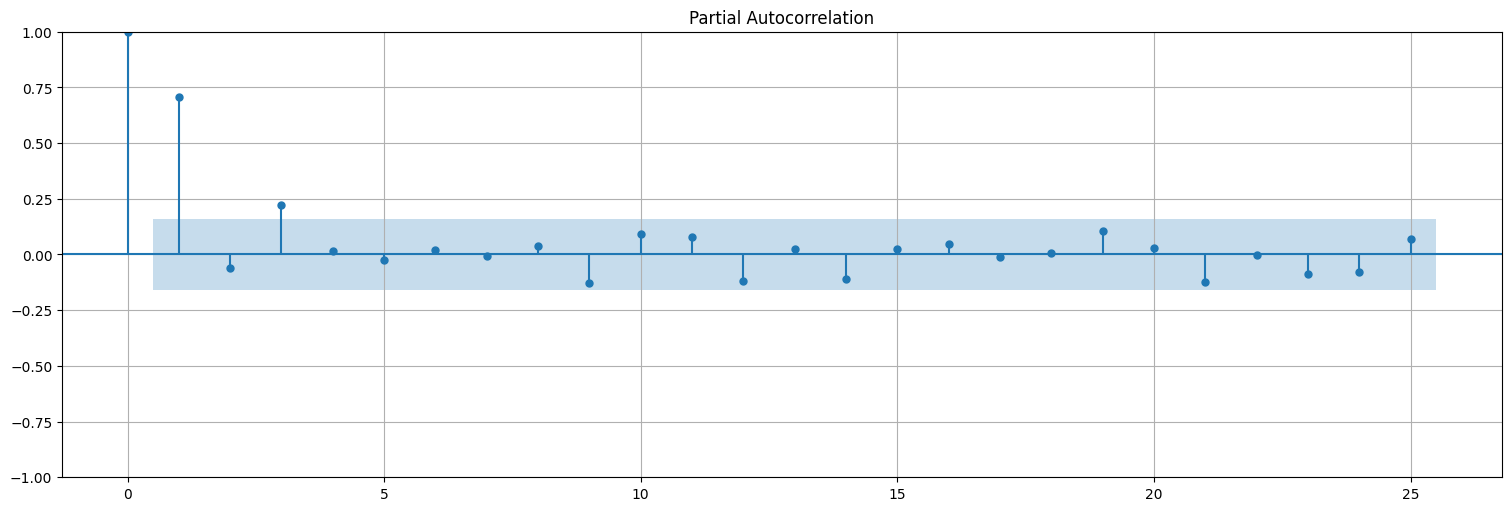

In [95]:
plot_pacf(salesfit_resid, lags=25);